In [ ]:
# START FROM HERE

#Part 1:

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# CIFAR-10 dataset project

*Introduction*

The CIFAR10 dataset consists of 60000 32x32 RGB images in 10 evenly distributed classes, with 6000 images per class. There are 50000 training images and 10000 test images.

the labels our models will be predicting are the classes , hence we are dealing with a multiclass classification problem. We shall split the data set for training and testing with the current structure of the dataset, meaning 80/20 train test split. ( as there are 50000 train images and 10000 test images).

below we shall show the following in regards to obtaining the dataset successfully:

- The datasets shape
- We shall show some sample images of the data
- The class distrubution in the training and testing set

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Transform data into tensors and normalize // subtract mean and deivde by standard deviation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# Define the classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("\nwe can see the batch sizes are 32 containing images of shape (3, 32, 32) , the images are 32x32 in RGB format\n\n")
# As a sanity check, we print out the size of the training and test data.
images, labels = next(iter(trainloader))
print('Training data shape: ', images.shape)
print('Training labels shape: ', labels.shape)

images, labels = next(iter(testloader))
print('Test data shape: ', images.shape)
print('Test labels shape: ', labels.shape)

Files already downloaded and verified
Files already downloaded and verified

we can see the batch sizes are 32 containing images of shape (3, 32, 32) , the images are 32x32 in RGB format


Training data shape:  torch.Size([32, 3, 32, 32])
Training labels shape:  torch.Size([32])
Test data shape:  torch.Size([32, 3, 32, 32])
Test labels shape:  torch.Size([32])


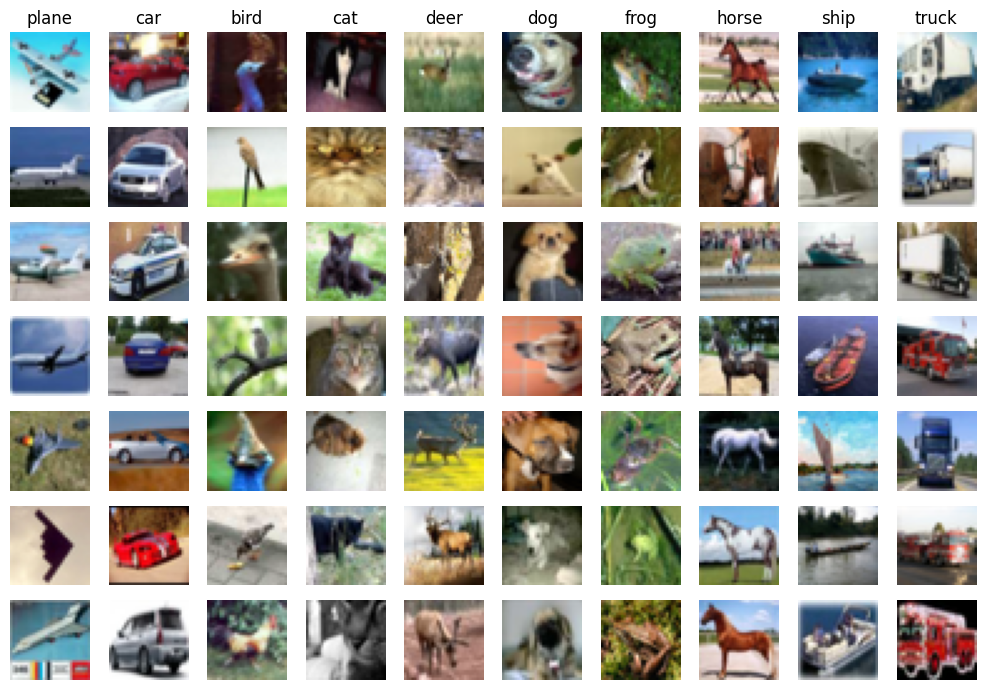

In [77]:
# Define the classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
num_classes = len(classes)
samples_per_class = 7

# Create a figure and subplots
fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(num_classes, samples_per_class))

for y, cls in enumerate(classes):
    # Get indices of images belonging to class y
    idxs = [idx for idx, label in enumerate(trainset.targets) if label == y]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)

    for i, idx in enumerate(idxs):
        img, _ = trainset[idx]  # Get image and label
        img = img.permute(1, 2, 0)  # Change to channels-last format
        img = img.numpy()  # Convert to numpy array
        img = (img - img.min()) / (img.max() - img.min())  # Normalize pixel values
        ax = axes[i, y]  # Get the subplot corresponding to this image
        ax.imshow(img)  # Display the image
        ax.axis('off')  # Turn off axis
        if i == 0:
            ax.set_title(cls)  # Set title for the first row

plt.tight_layout()  # Adjust layout
plt.show()


## Class distrubution in traning set:

one can see that the data is distrubuted evenly with the same amount of images per class, in the training and testing data

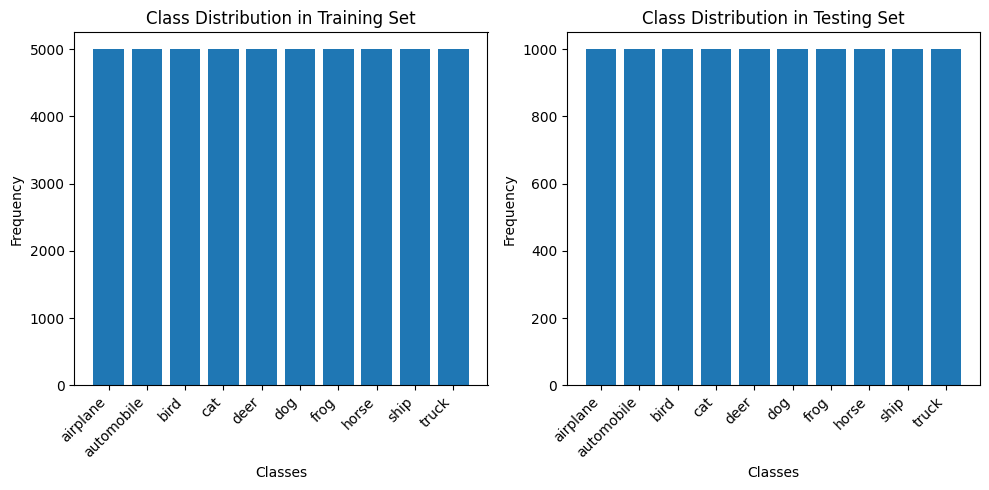

In [78]:
#show distrubution in training and testing set


# Get the class names
classes = trainset.classes

# Plotting the distribution of classes
def plot_class_distribution(dataset, dataset_name, position):
    class_counts = np.bincount(dataset.targets)
    num_classes = len(class_counts)

    plt.subplot(1, 2, position)
    plt.bar(range(num_classes), class_counts, tick_label=classes)
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

# Create a figure with two subplots
plt.figure(figsize=(10, 5))

# Plot class distribution for training and testing sets
plot_class_distribution(trainset, 'Training', 1)
plot_class_distribution(testset, 'Testing', 2)

plt.show()


#Part 2:

Our work in the follwing part involes our implementation of variouse models and how they compare to each. we tackel this problem by starting with initial attempts of simple models and building up apon them. we will disscuse how we improve our results in regaurds to loss, train error, validation error, overfitting and underfitting.

### Our models
- Dummy classifier
- simple Logistic Regresion model
- Softmax

##Dummy Classifier:
as expected the most common class is eqaul in our senerio (as all classes have the same amount of images in the test and trian data sets), hence when we predict we should recive 10% accuracy.

Let it be noted that any future model that dose not surpass this dummy classifier may be considered usless as this is our benchmark that one MUST pass in order to be considered usful.

In [79]:
from collections import Counter

# Define a dummy classifier class
class DummyClassifier:
    def __init__(self):
        self.most_common_class = None

    def fit(self, trainloader):
        # Count the occurrences of each class in the training set
        class_counts = Counter(trainloader.dataset.targets)
        # Find the most common class
        self.most_common_class = class_counts.most_common(1)[0][0]

    def predict(self, testloader):
        # Return predictions with the most common class for all samples
        return [self.most_common_class] * len(testloader.dataset)

# Initialize the dummy classifier
dummy_classifier = DummyClassifier()

# Fit the dummy classifier on the training data
dummy_classifier.fit(trainloader)

# Predict labels for the test data
predicted_labels = dummy_classifier.predict(testloader)

# Calculate accuracy
correct = sum(1 for predicted, actual in zip(predicted_labels, testloader.dataset.targets) if predicted == actual)
accuracy = correct / len(testloader.dataset) * 100

print(f'Dummy Classifier Accuracy: {accuracy:.2f}%')


Dummy Classifier Accuracy: 10.00%


# simple LOGISTIC REGRESION MODEL

Here we implement a model that out pefourms our Dummy classifier and gets a result of 40% accuracy. this is by using a using a simple logistic regresion model.

In [80]:
import torch.nn.functional as F

class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(32 * 32 * 3, 10)  # Input size: 32x32x3, Output size: 10 classes

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten the input tensor
        x = self.fc(x)
        return x

# Initialize Logistic Regression model
logistic_model = LogisticRegression()

# Define loss function and optimizer for Logistic Regression model
criterion_logistic = nn.CrossEntropyLoss()
optimizer_logistic = optim.SGD(logistic_model.parameters(), lr=0.001, momentum=0.9)

# Training loop for Logistic Regression model
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer_logistic.zero_grad()

        # forward + backward + optimize
        outputs = logistic_model(inputs)
        loss = criterion_logistic(outputs, labels)
        loss.backward()
        optimizer_logistic.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training Logistic Regression')

# Testing loop for Logistic Regression model
correct_logistic = 0
total_logistic = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = logistic_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_logistic += labels.size(0)
        correct_logistic += (predicted == labels).sum().item()

print('Logistic Regression Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct_logistic / total_logistic))


Finished Training Logistic Regression
Logistic Regression Accuracy of the network on the 10000 test images: 40 %


# Softmax
we next use a model that uses the relu function to break liniarity inorder to get better results. although our softmax NN is not deep and contains only 2 layers we get a accuracy of 52% outperforming our previouse simple logisitic regresion model.

## Sanity check loss
After building a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights to be about `log(C)` for `C` classes.

###in our case C = 10 as there are ten classes so one would expect log(10) ~ 2.30


In [81]:
# Define Softmax NN model
class SoftmaxNN(nn.Module):
    def __init__(self):
        super(SoftmaxNN, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize Softmax NN model
softmax_model = SoftmaxNN()

# Define loss function and optimizer for Softmax NN model
criterion_softmax = nn.CrossEntropyLoss()

# Sanity check for the loss
# Generate random inputs and labels
inputs = torch.randn(1000, 3, 32, 32)  # Batch size of 1000, RGB images of size 32x32
labels = torch.randint(0, 10, (1000,))  # Random labels

# Forward pass
outputs = softmax_model(inputs)
loss = criterion_softmax(outputs, labels)

# Print the loss
print(f'Sanity check loss: {loss.item()}')




Sanity check loss: 2.3337175846099854


In [82]:
optimizer_softmax = optim.SGD(softmax_model.parameters(), lr=0.001, momentum=0.9)

# Training loop for Softmax NN model
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer_softmax.zero_grad()

        # forward + backward + optimize
        outputs = softmax_model(inputs)
        loss = criterion_softmax(outputs, labels)
        loss.backward()
        optimizer_softmax.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training Softmax NN')

# Testing loop for Softmax NN model
correct_softmax = 0
total_softmax = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = softmax_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_softmax += labels.size(0)
        correct_softmax += (predicted == labels).sum().item()

print('Softmax NN Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct_softmax / total_softmax))

Finished Training Softmax NN
Softmax NN Accuracy of the network on the 10000 test images: 52 %


#Part 3:

Our work in the follwing part involes our implementation of two models and how they compare to each. we tackel this problem by starting with initial attempt of a simple convolutional neural network and then a Deeper more complexed convolutional nural network.

### Our models
- CNN
- Deep CNN

#CNN

## Sanity check loss
After we build a new network, one of the first things we should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights to be about `log(C)` for `C` classes.

###in our case C = 10 as there are ten classes so one would expect log(10) ~ 2.30

our netwrok is a x layered network using the relu function in the forward pass // say more about the network

In [83]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize CNN model
cnn_model = CNN()

# Define loss function and optimizer for CNN model
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

# Perform a forward pass with random inputs and labels to compute the initial loss
inputs = torch.randn(100, 3, 32, 32)  # Random inputs
labels = torch.randint(0, 10, (100,))  # Random labels
outputs = cnn_model(inputs)
initial_loss = criterion_cnn(outputs, labels)

# Print the initial loss
print(f'Initial loss: {initial_loss.item()}')

Initial loss: 2.304367780685425


#Traning Our model
When training our model we would like to print some infomation in regards to the train loss and validation loss to reasure we are not overfitting the model while training the model. our graph shows that indeed we are not overfitting the model. we see that the training loss and validation loss decrease together as expected throughout the training.

Epoch: 1, Validation Loss: 1.977
Epoch: 2, Validation Loss: 1.663
Epoch: 3, Validation Loss: 1.524
Epoch: 4, Validation Loss: 1.424
Epoch: 5, Validation Loss: 1.357
Epoch: 6, Validation Loss: 1.292
Epoch: 7, Validation Loss: 1.238
Epoch: 8, Validation Loss: 1.228
Epoch: 9, Validation Loss: 1.231
Epoch: 10, Validation Loss: 1.143


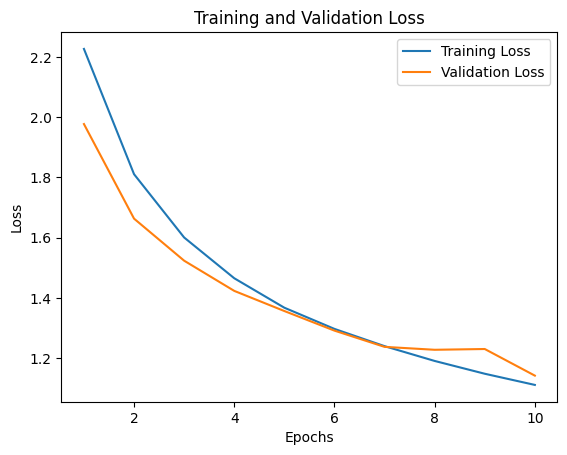

Finished Training CNN


In [84]:
# Training and validation loop for CNN model
train_losses = []
valid_losses = []
for epoch in range(10):  # loop over the dataset multiple times
    cnn_model.train()  # set model to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer_cnn.zero_grad()

        outputs = cnn_model(inputs)
        loss = criterion_cnn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # Validation
    cnn_model.eval()  # set model to evaluation mode
    valid_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = cnn_model(images)
            loss = criterion_cnn(outputs, labels)
            valid_loss += loss.item()

    # Calculate and store average training and validation losses
    train_losses.append(running_loss / len(trainloader))
    valid_losses.append(valid_loss / len(testloader))
    print('Epoch: %d, Validation Loss: %.3f' % (epoch + 1, valid_loss / len(testloader)))

# Plot training and validation loss over epochs
plt.plot(range(1, 11), train_losses, label='Training Loss')
plt.plot(range(1, 11), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print('Finished Training CNN')

#Accuracy

Finally we can see that our CNN produces an acuuracy of 59% outperforming our previouse models from Part 2.

In [85]:
# Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


#Deeper network

#Sanity check loss
After we build a new network, one of the first things we should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights to be about log(C) for C classes.

###in our case C = 10 as there are ten classes so one would expect log(10) ~ 2.30
our netwrok is a x layered network using the relu function in the forward pass // say more about the network

In [86]:
import torch.nn.functional as F

import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # Convolutional layer
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  # Convolutional layer
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling
        self.dropout1 = nn.Dropout2d(p=0.25)  # Dropout

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Convolutional layer
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)  # Convolutional layer
        self.bn4 = nn.BatchNorm2d(64)  # Batch normalization
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling
        self.dropout2 = nn.Dropout2d(p=0.25)  # Dropout

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Convolutional layer
        self.bn5 = nn.BatchNorm2d(128)  # Batch normalization
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)  # Convolutional layer
        self.bn6 = nn.BatchNorm2d(128)  # Batch normalization
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling
        self.dropout3 = nn.Dropout2d(p=0.25)  # Dropout

        self.flatten = nn.Flatten()  # Flatten layer
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Fully connected layer
        self.dropout4 = nn.Dropout(p=0.25)  # Dropout
        self.fc2 = nn.Linear(128, 10)  # Fully connected layer

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # Convolutional layer -> Batch normalization -> ReLU activation
        x = F.relu(self.bn2(self.conv2(x)))  # Convolutional layer -> Batch normalization -> ReLU activation
        x = self.pool1(x)  # Max pooling
        x = self.dropout1(x)  # Dropout

        x = F.relu(self.bn3(self.conv3(x)))  # Convolutional layer -> Batch normalization -> ReLU activation
        x = F.relu(self.bn4(self.conv4(x)))  # Convolutional layer -> Batch normalization -> ReLU activation
        x = self.pool2(x)  # Max pooling
        x = self.dropout2(x)  # Dropout

        x = F.relu(self.bn5(self.conv5(x)))  # Convolutional layer -> Batch normalization -> ReLU activation
        x = F.relu(self.bn6(self.conv6(x)))  # Convolutional layer -> Batch normalization -> ReLU activation
        x = self.pool3(x)  # Max pooling
        x = self.dropout3(x)  # Dropout

        x = self.flatten(x)  # Flatten
        x = F.relu(self.fc1(x))  # Fully connected layer -> ReLU activation
        x = self.dropout4(x)  # Dropout
        x = self.fc2(x)  # Fully connected layer
        return x

# Initialize CNN model
cnn_model = CNN()

# Define loss function and optimizer for CNN model
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

# Perform a forward pass with random inputs and labels to compute the initial loss
inputs = torch.randn(100, 3, 32, 32)  # Random inputs
labels = torch.randint(0, 10, (100,))  # Random labels
outputs = cnn_model(inputs)
initial_loss = criterion_cnn(outputs, labels)

# Print the initial loss
print(f'Initial loss: {initial_loss.item()}')


Initial loss: 2.312546491622925


#Model Summery
here we can see how our model is implemented and built in regards to its layers.

In [87]:
from torchsummary import summary

# Assuming cnn_model is your PyTorch model
summary(cnn_model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
       BatchNorm2d-4           [-1, 32, 32, 32]              64
         MaxPool2d-5           [-1, 32, 16, 16]               0
         Dropout2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9           [-1, 64, 16, 16]          36,928
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        MaxPool2d-11             [-1, 64, 8, 8]               0
        Dropout2d-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
      BatchNorm2d-14            [-1, 12

#Traning Our model
When training our model we would like to print some infomation in regards to the train loss and validation loss to reasure we are not overfitting the model while training the model. our graph shows that indeed we are not overfitting the model. we see that the training loss and validation loss decrease together as expected throughout the training.

Epoch: 1, Validation Loss: 1.305
Epoch: 2, Validation Loss: 1.110
Epoch: 3, Validation Loss: 0.938
Epoch: 4, Validation Loss: 0.901
Epoch: 5, Validation Loss: 0.812
Epoch: 6, Validation Loss: 0.785
Epoch: 7, Validation Loss: 0.729
Epoch: 8, Validation Loss: 0.708
Epoch: 9, Validation Loss: 0.669
Epoch: 10, Validation Loss: 0.668


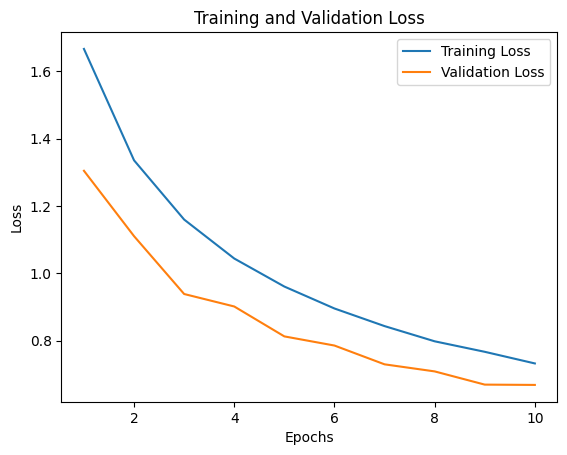

Finished Training CNN


In [88]:
# Training and validation loop for CNN model
train_losses = []
valid_losses = []
for epoch in range(10):  # loop over the dataset multiple times
    cnn_model.train()  # set model to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer_cnn.zero_grad()

        outputs = cnn_model(inputs)
        loss = criterion_cnn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # Validation
    cnn_model.eval()  # set model to evaluation mode
    valid_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = cnn_model(images)
            loss = criterion_cnn(outputs, labels)
            valid_loss += loss.item()

    # Calculate and store average training and validation losses
    train_losses.append(running_loss / len(trainloader))
    valid_losses.append(valid_loss / len(testloader))
    print('Epoch: %d, Validation Loss: %.3f' % (epoch + 1, valid_loss / len(testloader)))

# Plot training and validation loss over epochs
plt.plot(range(1, 11), train_losses, label='Training Loss')
plt.plot(range(1, 11), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

print('Finished Training CNN')

#Accuracy

Finally we can see that our Deeper CNN model produces an acuuracy of 76% outperforming our previouse CNN model previousely.

In [89]:
# Calculate accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %


#notes:

add recall and precision, confusion matrix